## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## Load all required libraries

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os 

## Support functions

In [49]:
def plot_imgs(img_list):
    fig=plt.figure(figsize=(24, 9))
    N_img = len(img_list)
    column = 3
    row = np.ceil(N_img/column)
    for idx, curr_img in enumerate(img_list):
        fig.add_subplot(row, column, idx+1)
        plt.imshow(curr_img)
    plt.show()

def plot_images(img, undist_img, combined_grad_img, color_img, binary_img, perspec_img):
    row = 2
    column = 3
    fig=plt.figure(figsize=(24, 9))
    fig.add_subplot(row, column, 1)
    plt.imshow(img)
    plt.title('Original Image', fontsize=15)
    fig.add_subplot(row, column, 2)
    plt.imshow(undist_img)
    plt.title('Undistorted Image', fontsize=15)
    fig.add_subplot(row, column, 3)
    plt.imshow(combined_grad_img)
    plt.title('Gradient Image', fontsize=15)
    fig.add_subplot(row, column, 4)
    plt.imshow(color_img)
    plt.title('Color Image', fontsize=15)
    fig.add_subplot(row, column, 5)
    plt.imshow(binary_img)
    plt.title('Binary Image', fontsize=15)
    fig.add_subplot(row, column, 6)
    plt.imshow(perspec_img)
    plt.title('Prespective Image', fontsize=15)
    plt.show()

## Compute the camera calibration matrix and distortion coefficients

In [4]:
def compute_calibration_coefficients(path, img_suffix, nx, ny):
    # prepare object points
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Join various path components  
    img_path = os.path.join(path, img_suffix)
    
    # Make a list of calibration images
    images = glob.glob(img_path + "*.jpg")
    
    if len(images) < 1:
        return [-1, 0, 0, 0, 0];
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            # Save corners
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        else:
            print("WARNING: no corner found in ", fname)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return [ret, mtx, dist, rvecs, tvecs]


## Correcting for camera distorition

In [5]:
def undistorted_image(raw_img, mtx, dist):
    # curr_undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    
    h,  w = raw_img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

    # undistort
    dst = cv2.undistort(raw_img, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    curr_undist = dst[y:y+h, x:x+w]
    
    return curr_undist


## Transform perspective  (DA FAR FUNZIONARE)

In [92]:
def perspective_transform(img, upper_pixel_length, upper_pixel_offset, lateral_pixel_offset):
    # compute the perspective transform vectors
    img_size = (img.shape[1], img.shape[0])
    src_points = np.float32([[(img_size[0]+upper_pixel_length)*.5, upper_pixel_offset],
                             [img_size[0]-lateral_pixel_offset, img_size[1]], 
                             [lateral_pixel_offset, img_size[1]], 
                             [(img_size[0]-upper_pixel_length)*.5, upper_pixel_offset]])
    dst_points = np.float32([[img_size[0]-lateral_pixel_offset, upper_pixel_offset],
                                 [img_size[0]-lateral_pixel_offset, img_size[1]], 
                                 [lateral_pixel_offset, img_size[1]], 
                                 [lateral_pixel_offset, upper_pixel_offset]])
    print("img size: ", img_size)
    print("persp_trans src: ", src_points)
    print("persp_trans dst: ", dst_points)
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Warp the image using the perspective transform
    print("M: ", M)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

## Gradient analysis function

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if 'x' == orient:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif 'y' == orient:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    else:
        print("Input orientation not valid. Please specify x or y")
        exit()
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobel = np.sqrt((sobelx*sobelx) + (sobely*sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # grayscale conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # sobel algorithm
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # compute gradient direction
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    grd_dir = np.arctan2(abs_y, abs_x)
    # binary_output = np.uint8(255*grd_dir/np.max(grd_dir))
    binary_output = np.zeros_like(grd_dir)
    binary_output[(grd_dir >= thresh[0]) & (grd_dir <= thresh[1])] = 1
    return binary_output

def combine_gradients(img, ksize, mod_thresh, dir_thresh):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=mod_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=mod_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=mod_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

## Color transformation

In [8]:
def color_transformation(img, s_thresh):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return s_binary
    
def combine_gradinet_with_color(grad_img, color_img):
    # combine the contribution of the two channel
    combined_binary = np.zeros_like(grad_img)
    combined_binary[(color_img == 1) | (grad_img == 1)] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(grad_img), grad_img, color_img)) * 255
    
    return [combined_binary, color_binary]


## Pipeline parameters

In [96]:
# prepare object points
nx = 9
ny = 6

# calibration img data
calibration_path = 'camera_cal'
img_suffix = 'calibration'

# raw img
raw_path = 'test_images'

# kernel size for sobel algorithms
ksize = 9

# threshold for gradinet binary convertion
mod_thresh = (30, 100)
dir_thresh = (0.7, 1.3)

# threshold for color binary conversion
s_thresh = (170, 255)

# perspective transform parameter
lateral_pixel_offset = 180
upper_pixel_offset = 300
upper_pixel_length = 80


## Pipeline

In [86]:
def advenced_lane_finding_pipeline(img, mtx, dist, upper_pixel_length, upper_pixel_offset, lateral_pixel_offset):
    # remove distortion from image
    undist_img = undistorted_image(img, mtx, dist)
    
    # compute combined gradient binary
    combined_grad_img = combine_gradients(undist_img, ksize, mod_thresh, dir_thresh)
    
    # compute color binary
    color_img = color_transformation(undist_img, s_thresh)
    
    # combine the two contributions
    binary_img, stack_img = combine_gradinet_with_color(combined_grad_img, color_img)
    
    # perspective transform
    perspec_img, M = perspective_transform(undist_img, upper_pixel_length, upper_pixel_offset, lateral_pixel_offset)
    
    plot_images(img, undist_img, combined_grad_img, color_img, binary_img, perspec_img)
    
    return perspec_img

In [57]:
def test_pipeline(path, mtx, dist):
    # output list
    final_imgs = list()
    
    # Make a list of calibration images
    images = glob.glob(os.path.join(path, "*.jpg"))
    
    if len(images) < 1:
        print("ERROR: no jpg file found in ", path)
        return [-1, final_img];
    
    # Step through the list and search for chessboard corners
    for fname in images:
        raw_img = cv2.imread(fname)
        curr_img = advenced_lane_finding_pipeline(raw_img, mtx, dist, upper_pixel_length, upper_pixel_offset, lateral_pixel_offset)
        final_imgs.append(curr_img)
        break
    return final_imgs

## Main

img size:  (1202, 621)
persp_trans src:  [[  626.   300.]
 [ 1022.   621.]
 [  180.   621.]
 [  576.   300.]]
persp_trans dst:  [[ 1022.   300.]
 [ 1022.   621.]
 [  180.   621.]
 [  180.   300.]]
M:  [[ -1.21995938e+00  -2.14846310e+00   1.33419559e+03]
 [ -8.34887715e-14  -2.29240352e+00   6.65987813e+02]
 [ -1.35308431e-16  -3.57481381e-03   1.00000000e+00]]


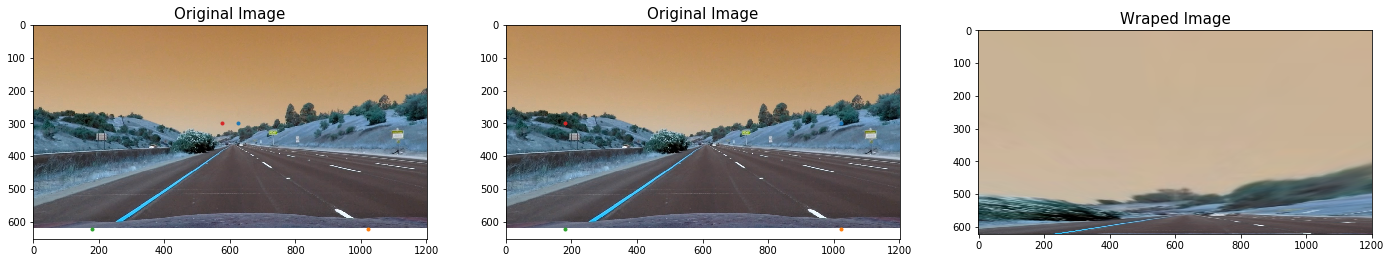

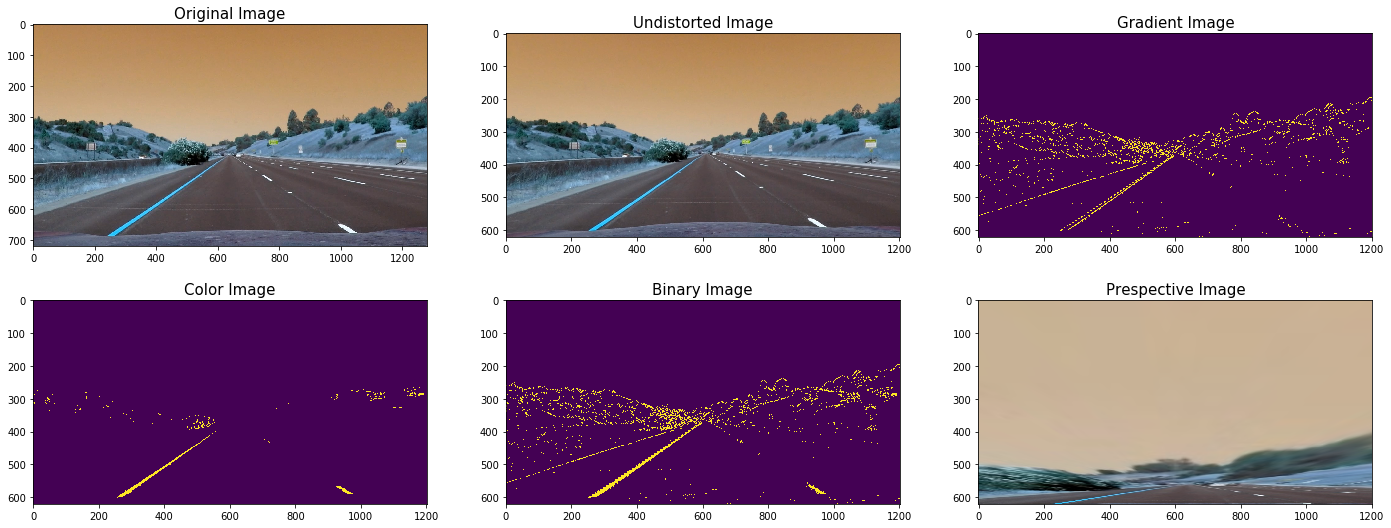

In [95]:
# compute the calibration matrix and distortion parameters
ret, mtx, dist, rvecs, tvecs = compute_calibration_coefficients(calibration_path, img_suffix, nx, ny)

# test pipeline using test_images content
fin_imgs = test_pipeline(raw_path, mtx, dist)
# plot_imgs(fin_imgs)